# Limpeza e EDA dos dados recebidos


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import spearmanr

## Leitura e carregamento dos dados

In [2]:
df = pd.read_csv('../data/vendas_jittered.csv')
df.head()

,Data,Produto,Quantidade,ValorMedio,Total,Func,Ndoc,Tipo,CST,NCM,Codigo,Categoria
0,2015-01-02,OLEO SELENIA SPRINTA 4T 20W-50,1.0,11.70,11.70,4,24039,C,60,27101932,913,OLEO
1,2015-01-02,PNEU TRAS. BIZ LEVORIN DAKA 80/100X14,1.0,109.25,109.25,3,24049,C,60,40114000,829,PNEU
2,2015-01-02,CAMARA AR CG/TITAN LEVORIN (SA 18),1.0,24.61,24.61,4,24039,C,60,40139000,442,CAMARA
3,2015-01-02,CAMARA AR TRAS. BROS/XLR 250 PIRELLI,1.0,37.75,37.75,4,24043,C,60,40139000,1376,CAMARA
4,2015-01-02,CABO EMB. KS/ES 2002/08 FAN IMP/CG-83,1.0,10.39,10.39,3,24037,C,60,84831030,2146,CABO


## Análise

### Início da análise estrutural dos dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255895 entries, 0 to 255894
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Data        255895 non-null  object 
 1   Produto     255895 non-null  object 
 2   Quantidade  255895 non-null  float64
 3   ValorMedio  255895 non-null  float64
 4   Total       255895 non-null  float64
 5   Func        255895 non-null  int64  
 6   Ndoc        255895 non-null  int64  
 7   Tipo        255895 non-null  object 
 8   CST         255895 non-null  int64  
 9   NCM         255895 non-null  int64  
 10  Codigo      255895 non-null  int64  
 11  Categoria   255895 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 23.4+ MB


In [4]:
df.describe()

,Quantidade,ValorMedio,Total,Func,Ndoc,CST,NCM,Codigo
count,255895.000000,255895.000000,255895.000000,255895.000000,255895.000000,255895.000000,2.558950e+05,255895.000000
mean,1.278110,21.954933,23.406216,3.636097,67053.554774,58.289619,6.895641e+07,3055.969562
std,1.095199,35.574053,38.087845,1.009804,51968.250656,10.749343,2.257513e+07,2518.062502
min,1.000000,0.100000,0.100000,0.000000,1.000000,0.000000,2.710193e+07,1.000000
25%,1.000000,3.890000,4.660000,3.000000,17108.000000,60.000000,4.016930e+07,787.000000
50%,1.000000,11.220000,12.300000,4.000000,60796.000000,60.000000,8.421310e+07,2635.000000
75%,1.000000,22.600000,23.660000,4.000000,111154.500000,60.000000,8.714100e+07,5060.000000
max,178.000000,762.310000,1699.080000,9.000000,166092.000000,260.000000,9.613900e+07,8971.000000


Analisando a coluna quantidade, podemos ver que até o terceiro quartil temos o valor 1, o que indica que grande parte dos itens são vendidos em unidade.
Já o valor Médio, podemos ver que, em média, os valores não são altos.
Com essas duas informações já sabemos, também, que o valor total, em média, não será muito elevado, o que se confirma.


In [5]:
df.describe(include='object')

,Data,Produto,Tipo,Categoria
count,255895,255895,255895,255895
unique,3054,6582,2,223
top,2016-09-02,OLEO SELENIA SPRINTA 4T 20W-50,P,OLEO
freq,286,8937,163009,24361


### Remoção de colunas que não utilizaremos
Não utilizaremos as colunas NCM e CST

In [6]:
df.drop(columns=['CST', 'NCM'], inplace=True)

### Conversão dos dados necessários

Podemos ver que temos que categorizar os Funcinoários (não queremos simular uma hierarquia entre eles), converter Data para datetime e mudar quantidade para valores inteiros, não se vende "valores quebrados" de peças.

In [7]:
df['Func'] = df['Func'].astype('category')
df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d')

In [8]:
df.head()

,Data,Produto,Quantidade,ValorMedio,Total,Func,Ndoc,Tipo,Codigo,Categoria
0,2015-01-02,OLEO SELENIA SPRINTA 4T 20W-50,1.0,11.70,11.70,4,24039,C,913,OLEO
1,2015-01-02,PNEU TRAS. BIZ LEVORIN DAKA 80/100X14,1.0,109.25,109.25,3,24049,C,829,PNEU
2,2015-01-02,CAMARA AR CG/TITAN LEVORIN (SA 18),1.0,24.61,24.61,4,24039,C,442,CAMARA
3,2015-01-02,CAMARA AR TRAS. BROS/XLR 250 PIRELLI,1.0,37.75,37.75,4,24043,C,1376,CAMARA
4,2015-01-02,CABO EMB. KS/ES 2002/08 FAN IMP/CG-83,1.0,10.39,10.39,3,24037,C,2146,CABO


In [9]:
df['Quantidade'] = df['Quantidade'].astype(int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255895 entries, 0 to 255894
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Data        255895 non-null  datetime64[ns]
 1   Produto     255895 non-null  object        
 2   Quantidade  255895 non-null  int64         
 3   ValorMedio  255895 non-null  float64       
 4   Total       255895 non-null  float64       
 5   Func        255895 non-null  category      
 6   Ndoc        255895 non-null  int64         
 7   Tipo        255895 non-null  object        
 8   Codigo      255895 non-null  int64         
 9   Categoria   255895 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 17.8+ MB


### Contagem dos valores nulos

In [11]:
df.isna().sum()

Data          0
Produto       0
Quantidade    0
ValorMedio    0
Total         0
Func          0
Ndoc          0
Tipo          0
Codigo        0
Categoria     0
dtype: int64

Não temos valores nulos!

---

### Cardinalidade 

In [12]:
print('-- Cada coluna possui os seguintes valores únicos:')
print("Produtos únicos:", df['Produto'].nunique())
print("Categorias únicas:", df['Categoria'].nunique())
print("Funcionários únicos:", df['Func'].nunique())
print("Nº de vendas (Ndoc):", df['Ndoc'].nunique())

-- Cada coluna possui os seguintes valores únicos:
Produtos únicos: 6582
Categorias únicas: 223
Funcionários únicos: 9
Nº de vendas (Ndoc): 113075


### Análise de Produtos/Categorias
Vamos ver quais produtos e categorias são mais e menos frequentes.
Representando os produtos mais e menos vendidos.

In [13]:
prod_freq = df['Produto'].value_counts()
prod_freq.head(10)

Produto
OLEO SELENIA SPRINTA 4T 20W-50           8937
OLEO DULUB MOTO 4T 20W50 SL              3404
OLEO LUBRAX GP MOTO 4T 20W50             3307
OLEO MOBIL 4T 20 W 50                    2954
ROLAM. 6301 IMP. - DIANT. CG             1978
VISEIRA CAPACETE SAN MARINO CRISTAL 0    1740
LAMP. STOP CG 12V - IMP.                 1624
OLEO MOTO 4T 20W50                       1571
RET. VALVULA BIZ/TIT150/2002/03/04 MA    1530
SERV. CAPA BANCO                         1528
Name: count, dtype: int64

In [14]:
print(prod_freq.tail(10))

Produto
GUARNICAO ESCAP. CB 400 (GR)             1
RET. MESA BIZ PART.(INT.ELETRICA) VED    1
CORRENTE COM. POP-110I 90L WGK           1
MACANETA FREIO POP 110I 2018/22 3165     1
ESTATOR COMPL. BROS 150 09/14 ZOUIL-1    1
KIT EMB. CG-150 WGK                      1
CABO FREIO CG/FAN 150 2014/15/CG160      1
INTERRUP. IGNIC. BIZ-110I 2016/17 C/T    1
PARALAMA DIANT. BIZ 04/05 VERM.          1
VIRABREQUIM CG-150 S/ROLAM.AUDAX         1
Name: count, dtype: int64


4 dos 5 produtos mais vendidos são óleo.

In [15]:
cat_freq = df['Categoria'].value_counts(normalize=True) * 100
print(cat_freq)

Categoria
OLEO           9.519920
RET.           5.379159
PARAF.         5.233787
LAMP.          4.140761
JUNTA          4.127865
                 ...   
GANCHO         0.000391
CORPO          0.000391
LIMITADOR      0.000391
BORRACHA       0.000391
VIRABREQUIM    0.000391
Name: proportion, Length: 223, dtype: float64


Aqui acima temos as categorias que mais vendem em porcentagem.
Possivelmente as de baixa frequência podem ser colocadas junto a outra categoria.

In [16]:
print(cat_freq.head(10))

Categoria
OLEO       9.519920
RET.       5.379159
PARAF.     5.233787
LAMP.      4.140761
JUNTA      4.127865
CABO       3.768342
PORCA      2.801930
KIT        2.655777
ROLAM.     2.499072
ARRUELA    1.950409
Name: proportion, dtype: float64


In [17]:
print(cat_freq.tail(10))

Categoria
X-PNEU         0.000391
LAMPADA        0.000391
DOBRADICA      0.000391
X-PASTILHA     0.000391
SACA           0.000391
GANCHO         0.000391
CORPO          0.000391
LIMITADOR      0.000391
BORRACHA       0.000391
VIRABREQUIM    0.000391
Name: proportion, dtype: float64


Text(0, 0.5, 'Vendas')

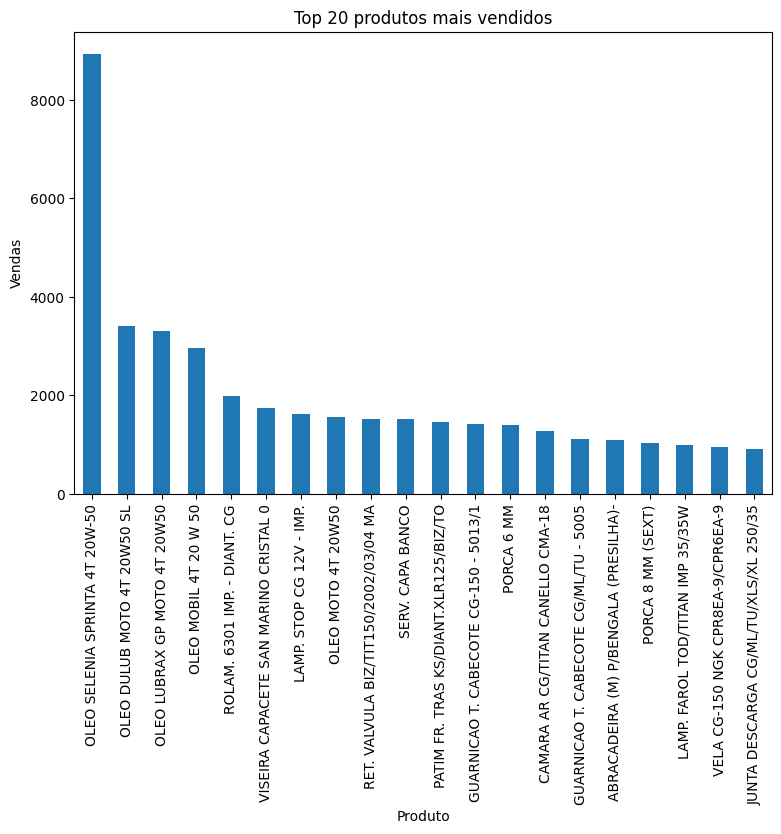

In [18]:
prod_freq[0:20].plot(kind='bar', figsize=(9,6), title='Top 20 produtos mais vendidos')
plt.xlabel('Produto')
plt.ylabel('Vendas')

---

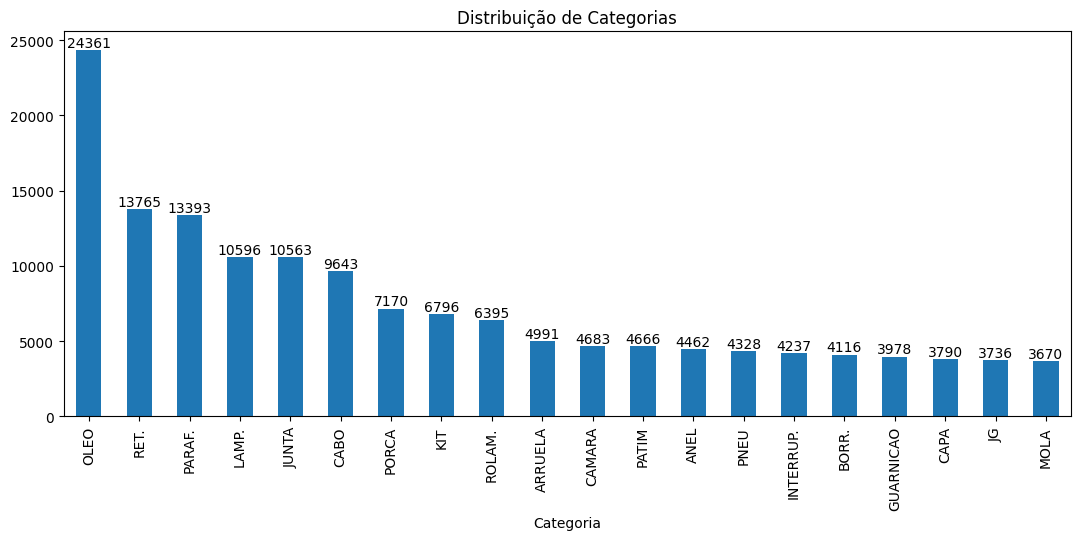

In [19]:
cat_freq_nao_norm = df['Categoria'].value_counts()
ax = cat_freq_nao_norm[0:20].plot(kind='bar', figsize=(13,5), title='Distribuição de Categorias')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.show()

#### Análise rápida da frequência dos funcionários

In [20]:
func_freq = df['Func'].value_counts()
print(func_freq.describe())

count         9.000000
mean      28432.777778
std       49959.140605
min           2.000000
25%         397.000000
50%        3291.000000
75%       12528.000000
max      126912.000000
Name: count, dtype: float64


In [21]:
func_freq

Func
4    126912
3    104451
7     12528
2      7619
1      3291
0       690
8       397
9         5
6         2
Name: count, dtype: int64

A loja tem 2 principais vendedores, com mais de 100mil vendas cada, enquanto o terceiro maior tem apenas 12mil vendas cadastradas. Os outros funcinários podem ter tido pouco tempo de trabalho, ou apenas tem outras funções dentro da loja. <br/>
Vamos ver um **gráfico**:

Text(0, 0.5, 'Número de Vendas')

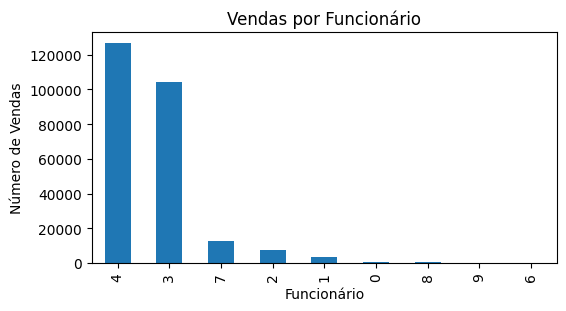

In [22]:
func_freq.plot(kind='bar', figsize=(6,3), title='Vendas por Funcionário')
plt.xlabel('Funcionário')
plt.ylabel('Número de Vendas')

### Análise Univariada das colunas

#### Variáveis Numéricas
Temos como variaveis numéricas `Quantidade`, `ValorMedio`, `Total`. Então vamos analisar separadamente cada uma para entender suas distribuições, valores extremos, assimetrias e sazonalidade.

##### Histograma


<Axes: xlabel='Total', ylabel='Count'>

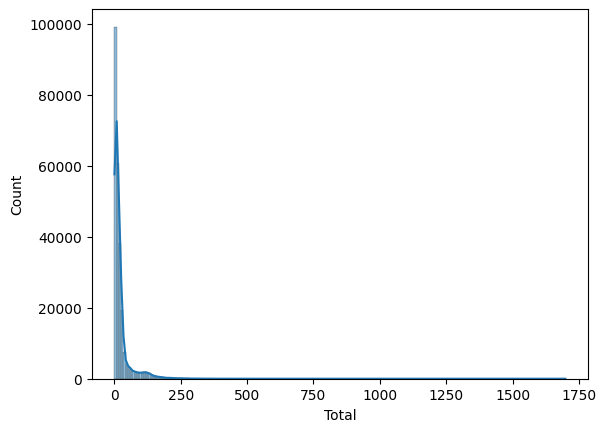

In [23]:
sns.histplot(df['Total'], bins=200, kde=True)

<Axes: xlabel='Quantidade', ylabel='Count'>

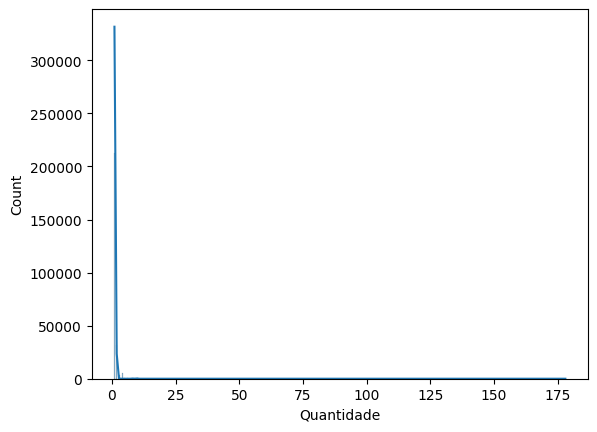

In [24]:
sns.histplot(df['Quantidade'], bins=500, kde=True)

<Axes: xlabel='ValorMedio', ylabel='Count'>

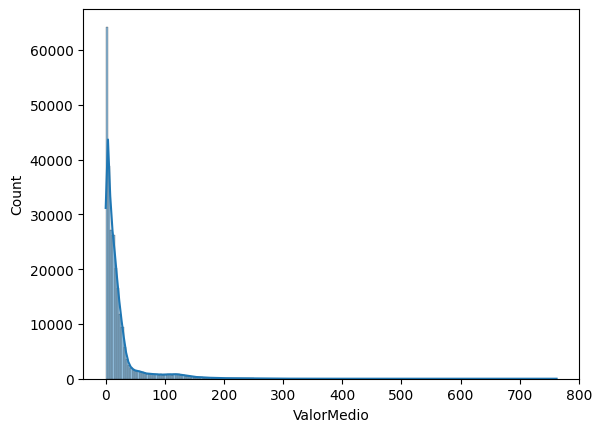

In [25]:
sns.histplot(df['ValorMedio'], bins=200, kde=True)

##### Análise da coluna ValorMedio

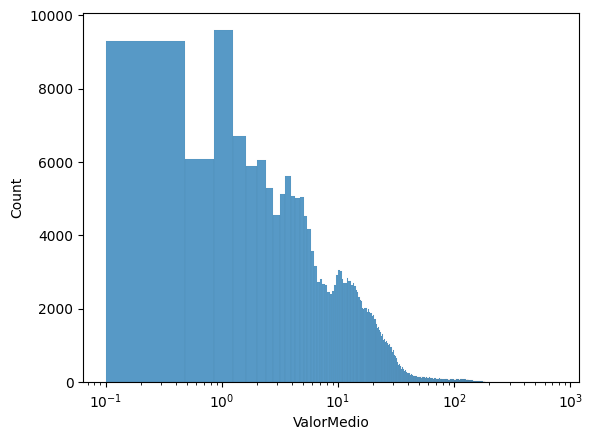

In [26]:
sns.histplot(df['ValorMedio'], bins=2000)
plt.xscale('log')
plt.show()

<Axes: ylabel='ValorMedio'>

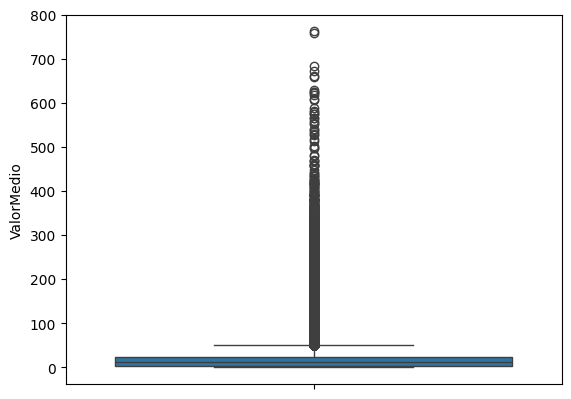

In [27]:
sns.boxplot(df['ValorMedio'])

Podemos ver que todas as peças de valor medio acima de aproximadamente R$80,00 são consideradas outliers.

##### Análise da coluna Quantidade

In [28]:
df['Quantidade'].describe()

count    255895.000000
mean          1.278110
std           1.095199
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         178.000000
Name: Quantidade, dtype: float64

Podemos ver a mediana muito próxima da média, o que indica que os dados estão bem distribuidos. No entanto podemos ver que grande parte é porque o valor é 1.
Com o máximo de 178, teremos muitos considerados como outliers. <br/>
Vamos ver o boxplot como fica:

<Axes: ylabel='Quantidade'>

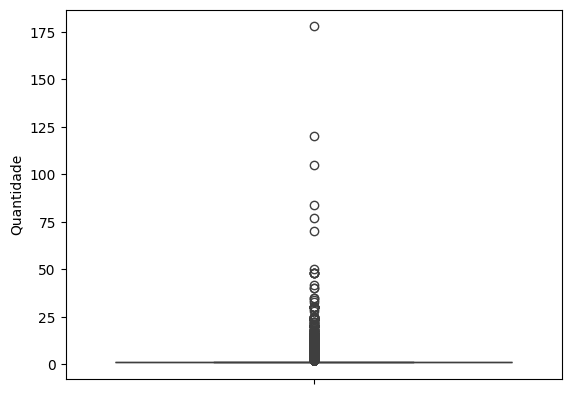

In [29]:
sns.boxplot(df['Quantidade'])

<Axes: ylabel='Quantidade_log'>

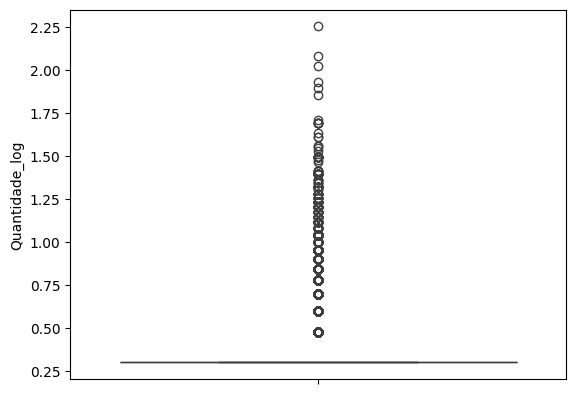

In [30]:
df['Quantidade_log'] = np.log10(df['Quantidade']+1)
sns.boxplot(df['Quantidade_log'])

Fazendo uma análise com log na base 10 consguimos ver de onde começam os outliers, como é uma coluna som valores do tipo inteiro sabemos que o valor é 2. <BR/>
x=Quantidade+1 <br/>
log10​(x)=0.50 <br/>
0.5 * ln(10) =~ 0.5 * 2.3 =~ 1.15 (aproximadamente)<br/>
e^1.15 =~ 3.15 =~ x (aproximadamente) <br/>
Como x é Quantidade + 1:    3.15 = Q + 1 <br>
Q = 3.15 - 1 = 2.15

Ou seja, qualquer valor de 2 para cima é considerado um outlier.

##### Análise da coluna Total

Intuitivamente com as análises anteriores teremos um resultado muito próximo de "ValorMedio", afinal a "Quantidade" é quase sempre 1. Vejamos

<Axes: ylabel='Total'>

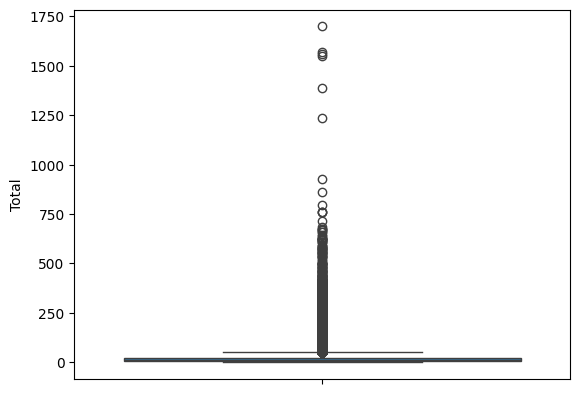

In [31]:
sns.boxplot(df['Total'])

O limite superior do boxplot é próximo a 100, assim como o "ValorMedio" que era em 80.

Mas é verdade que essas três colunas não contam a história completa, afinal os dados foram separados de forma que o pedido pode ser composto de várias linhas. Depois das análises individuais vamos fazer a junção e então uma análise de **ticket médio**.

#### Variáveis Categóricas

##### Categoria

In [32]:
cat_order = df.groupby('Categoria')['Total'].sum().sort_values(ascending=False).index

In [33]:
cat_order[0:25] # Apenas o top 15, para ficar visível

Index(['PNEU', 'KIT', 'OLEO', 'BATERIA', 'CILINDRO', 'CAPACETE', 'PISTAO/ANEL',
       'CABO', 'CAMARA', 'RET.', 'ROLAM.', 'PATIM', 'LAMP.', 'AMORTEC.', 'JG',
       'INTERRUP.', 'PEDAL', 'ARO', 'CONJUNTO', 'CAPA', 'CAIXA', 'CARBURADOR',
       'ESPELHO', 'EIXO', 'DISCO'],
      dtype='object', name='Categoria')

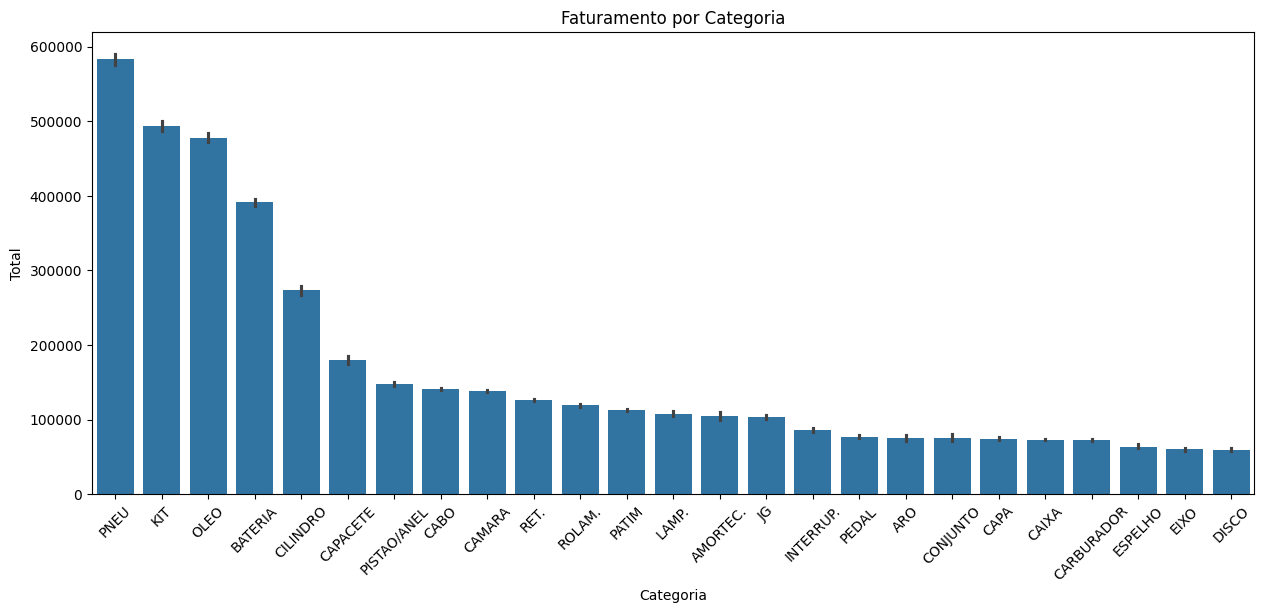

In [34]:
plt.figure(figsize=(15,6))
sns.barplot(data=df, x='Categoria', y='Total', order=cat_order[0:25], estimator=sum)
plt.xticks(rotation=45)
plt.title('Faturamento por Categoria')
plt.show()

Podemos ver que as 5 melhores categorias são: *Pneu*, *Kit*, *Oleo*, *Bateria* e *Cilindro*<BR>
Depois iremos fazer esta análise ao longo do tempo para ver se houve alguma mudança no top 10, e assim ver o comportamento do mercado, notando categorias que estarão em ascenção ou declínio.

##### Funcionário

In [35]:
func_faturamento_order = df.groupby('Func')['Total'].sum()

C:\Users\Igor\AppData\Local\Temp\ipykernel_12688\1408201187.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  func_faturamento_order = df.groupby('Func')['Total'].sum()


In [36]:
func_faturamento_order

Func
0    3.499277e+04
1    1.107424e+05
2    1.233343e+05
3    2.508026e+06
4    2.923487e+06
6    2.352000e+01
7    2.791647e+05
8    9.524390e+03
9    2.378300e+02
Name: Total, dtype: float64

<span style='color:red'>**OBS**</span>: O valor 'total' do Func 1 aqui está com mais de uma casa decimal, provavelmente é por causa de floating point.

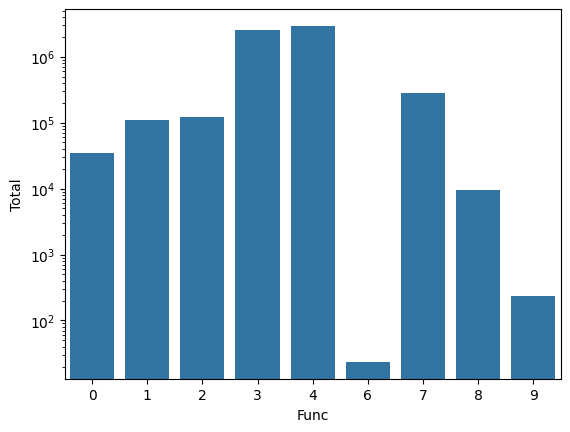

In [37]:
sns.barplot(func_faturamento_order)
plt.yscale('log')
plt.show()

Vamos comparar com a frequência de venda de cada funcionário, vamos ver se tem algum funcionário que aparenta vendar as peças mais caras.

In [38]:
func_freq

Func
4    126912
3    104451
7     12528
2      7619
1      3291
0       690
8       397
9         5
6         2
Name: count, dtype: int64

<Axes: xlabel='Func', ylabel='count'>

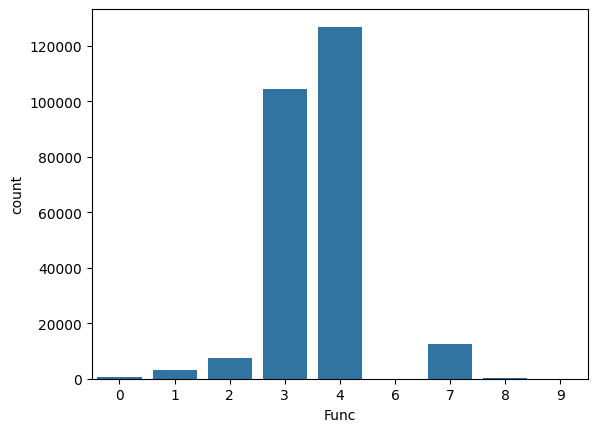

In [39]:
sns.barplot(func_freq)

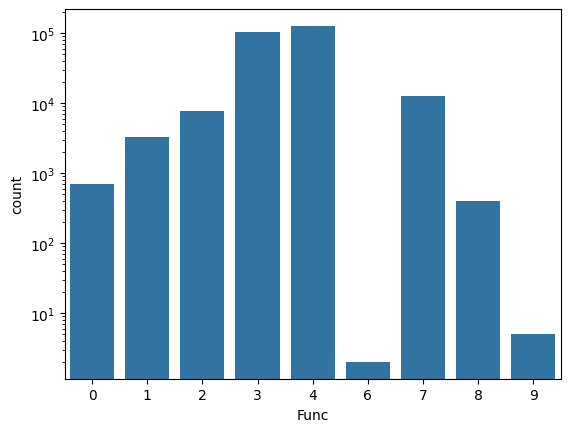

In [40]:
sns.barplot(func_freq)
plt.yscale('log')
plt.show()

In [41]:
func_faturamento_order/func_freq

Func
0    50.714159
1    33.650062
2    16.187728
3    24.011512
4    23.035547
6    11.760000
7    22.283258
8    23.990907
9    47.566000
dtype: float64

Em média, os funcionários *0* e *9* costuma vender itens mais caros.

In [42]:
(func_faturamento_order/func_freq).describe()

count     9.000000
mean     28.133241
std      13.337447
min      11.760000
25%      22.283258
50%      23.990907
75%      33.650062
max      50.714159
dtype: float64

##### Tipo de venda

In [43]:
df['Tipo'].value_counts()

Tipo
P    163009
C     92886
Name: count, dtype: int64

Temos quase 2 vezes de pedidos tipo *P* do que tipo *C*.<BR>
Tipo *P* deve ser pedido, e tipo *C* deve ser crediário. <br>
Faz sentido afinal se abre crediário para alguns clientes escolhidos e confiáveis.

Checkando o valor de cada:

In [44]:
total_tipo = df.groupby('Tipo')['Total'].sum()
total_tipo

Tipo
C    2.963755e+06
P    3.025778e+06
Name: Total, dtype: float64

<Axes: xlabel='Tipo', ylabel='Total'>

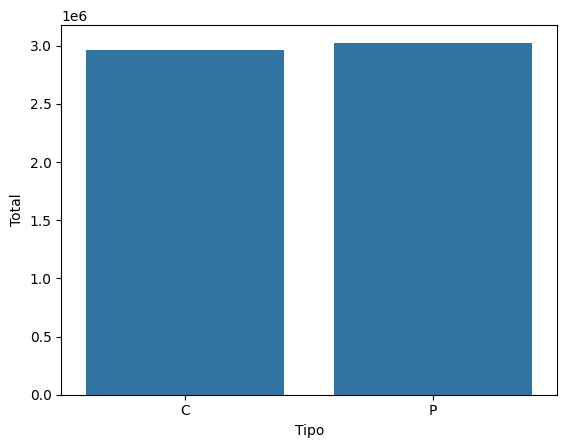

In [45]:
sns.barplot(total_tipo)

Apesar da diferença tamanho para crediário e pedidos, o faturamento total de cada é bem semelhante. <br>
Faz sentido pensar que clientes com conta na loja usam seus crediários para comprar produtos mais caros e irem pagando parceladamente.

##### Produto
Para produto podemos analisar a frequência de venda de cada produto.
<span style='color:red'>Aqui devemos tomar um cuidado especial, pois cada contagem de linha pode ter uma certa quantidade de produtos diferente de 1.</span> Como analisamos antes, vimos a raridade desta ocorrencia, mas ainda assim devemos fazer a contagem considerando a *quantidade*. <br>
Vamos ver como seria a diferença:

In [46]:
df['Produto'].value_counts()[0:10]

Produto
OLEO SELENIA SPRINTA 4T 20W-50           8937
OLEO DULUB MOTO 4T 20W50 SL              3404
OLEO LUBRAX GP MOTO 4T 20W50             3307
OLEO MOBIL 4T 20 W 50                    2954
ROLAM. 6301 IMP. - DIANT. CG             1978
VISEIRA CAPACETE SAN MARINO CRISTAL 0    1740
LAMP. STOP CG 12V - IMP.                 1624
OLEO MOTO 4T 20W50                       1571
RET. VALVULA BIZ/TIT150/2002/03/04 MA    1530
SERV. CAPA BANCO                         1528
Name: count, dtype: int64

In [47]:
produto_freq = df.groupby('Produto')['Quantidade'].sum().sort_values(ascending=False)
produto_freq[0:10]

Produto
OLEO SELENIA SPRINTA 4T 20W-50           10198
ROLAM. 6301 IMP. - DIANT. CG              3985
OLEO DULUB MOTO 4T 20W50 SL               3773
OLEO LUBRAX GP MOTO 4T 20W50              3433
RET. VALVULA BIZ/TIT150/2002/03/04 MA     3360
OLEO MOBIL 4T 20 W 50                     3232
PORCA 6 MM                                3181
ABRACADEIRA (M) P/BENGALA (PRESILHA)-     3108
BUCHA COROA CG (NAYLON)-3025              2292
PORCA 8 MM (SEXT)                         2238
Name: Quantidade, dtype: int64

Podemos ver que houve uma diferença no top 10. Depois iremos analisar também quais produtos tendem a sair em quantidades maiores que 1, e também quais produtos tendem a sair juntos, para criar insights mais interessantes para a loja.

In [48]:
total_produto = df.groupby('Produto')['Total'].sum().sort_values(ascending=False)

In [49]:
total_produto[0:10]

Produto
OLEO SELENIA SPRINTA 4T 20W-50           151346.88
BATERIA ERBS ERX 6-BS                    104240.61
PNEU TRAS. CG 150 VIPAL 90/90-18 ST-3     94746.65
OLEO LUBRAX GP MOTO 4T 20W50              79032.27
OLEO MOBIL 4T 20 W 50                     74769.22
BATERIA KOMOTORS KTX 6                    62352.98
OLEO DULUB MOTO 4T 20W50 SL               57581.84
PNEU TRAS. BIZ VIPAL ST-200 80/100-14     47927.32
PNEU DIANT. CG 150 VIPAL ST-300 2.75X     40733.68
PATIM FR. TRAS KS/DIANT.XLR125/BIZ/TO     40138.78
Name: Total, dtype: float64

In [50]:
total_produto.keys()[0]

'OLEO SELENIA SPRINTA 4T 20W-50'

##### Número do Pedido

In [51]:
df['Ndoc'].value_counts()

Ndoc
6911      147
15234     105
42         91
438        71
131427     70
         ... 
1788        1
1805        1
166045      1
166054      1
166039      1
Name: count, Length: 113075, dtype: int64

In [52]:
df.loc[df['Ndoc'] == 6911]

,Data,Produto,Quantidade,ValorMedio,Total,Func,Ndoc,Tipo,Codigo,Categoria,Quantidade_log
11232,2016-09-02,CABO FREIO KS 2000/2001 IMP./SCUD,1,13.31,13.31,3,6911,C,5012,CABO,0.30103
11240,2016-09-02,OLEO 4T SPEEDY SJ-20W50,1,9.72,9.72,3,6911,C,4103,OLEO,0.30103
11248,2016-09-02,PNEU DIANT. CG 150 VIPAL ST-200 2.75X,1,96.98,96.98,3,6911,C,6222,PNEU,0.30103
11250,2016-09-02,PNEU TRAS. CG 150 VIPAL 90/90-18 ST-2,1,106.24,106.24,3,6911,C,6124,PNEU,0.30103
11254,2016-09-02,VELA KS/ES 002/003 DPR8EA-9 ORIG.-980,1,14.14,14.14,3,6911,C,1999,VELA,0.30103
...,...,...,...,...,...,...,...,...,...,...,...
11465,2016-09-02,PISTAO/ANEL 0.25 CG METAL LEVE-1366.0,1,45.91,45.91,3,6911,C,4091,PISTAO/ANEL,0.30103
11467,2016-09-02,BIELA CG 83 METAL LEVE 1367,1,57.72,57.72,3,6911,C,2850,BIELA,0.30103
11468,2016-09-02,VALV. ADM. CG (RIC-5170),1,16.54,16.54,3,6911,C,1882,VALV.,0.30103
11473,2016-09-02,LAMP. FAROL TOD/TITAN IMP 35/35W,1,6.91,6.91,3,6911,C,457,LAMP.,0.30103


Há alguma coisa estranha, pois o mesmo pedido aparece uma vez em `2020-08-19` e várias também `2016-09-02` 

In [53]:
df[['Ndoc','Tipo']].value_counts()

Ndoc    Tipo
6911    C       147
15234   C       105
42      C        91
438     C        71
131427  P        70
               ... 
166073  P         1
166070  P         1
166069  P         1
166066  P         1
150286  P         1
Name: count, Length: 113075, dtype: int64

Temos no total 11308 vendas, incluindo `Pedidos` e `Crediários`. O número não muda separando ou não por Tipo, o que nos indica que os tipos de vendas tem o mesmo identificador organizacional de venda.

#### Variável Temporal

In [54]:
df['Data'].dt.freq
# print(df['Data'].dt.freq)


Temos a frequência como `None`, o que indica que o pandas não conseguiu detectar uma frequência. Para a análise temporal depois precisaremos arrajar um jeito de arrumar.

In [55]:
df.sort_values('Data', inplace=True)


In [56]:
df

,Data,Produto,Quantidade,ValorMedio,Total,Func,Ndoc,Tipo,Codigo,Categoria,Quantidade_log
0,2015-01-02,OLEO SELENIA SPRINTA 4T 20W-50,1,11.70,11.70,4,24039,C,913,OLEO,0.301030
92915,2015-01-02,CORR. CG-150 -GX/POWER CROSS/GX (428H,1,18.86,18.86,4,32083,P,3211,CORR.,0.301030
92916,2015-01-02,CORR. CG-150 -GX/POWER CROSS/GX (428H,1,20.96,20.96,3,32108,P,3211,CORR.,0.301030
92917,2015-01-02,RET. SUSP. CG.BIZ/TIT/KS (CORTECO)-41,1,4.66,4.66,2,32068,P,868,RET.,0.301030
92918,2015-01-02,RET. SUSP. CG.BIZ/TIT/KS (CORTECO)-41,1,4.65,4.65,4,32057,P,868,RET.,0.301030
...,...,...,...,...,...,...,...,...,...,...,...
92865,2025-03-31,TRAVA COROA CG/TOD/TIT.,1,4.16,4.16,4,24951,C,310,TRAVA,0.301030
92866,2025-03-31,ESPACADOR COROA KS/ES/CBX/200,1,5.44,5.44,4,24951,C,2790,ESPACADOR,0.301030
92867,2025-03-31,CUPILHA CONTRA PINO PQ 1.5X30,1,0.94,0.94,4,24960,C,5668,CUPILHA,0.301030
255857,2025-03-31,JUNTA T. LAT. ESQ. POP-110,1,8.77,8.77,4,166075,P,796,JUNTA,0.301030


In [57]:
df['Data'].min(), df['Data'].max()

(Timestamp('2015-01-02 00:00:00'), Timestamp('2025-03-31 00:00:00'))

Começamos com os dados em `02/01/2015` e terminamos em `31/03/2025`.

In [58]:
df.set_index('Data').resample('D').size()

Data
2015-01-02     63
2015-01-03     60
2015-01-04      0
2015-01-05     84
2015-01-06    101
             ... 
2025-03-27     52
2025-03-28     48
2025-03-29     44
2025-03-30      0
2025-03-31     72
Freq: D, Length: 3742, dtype: int64

Temos datas sem entrada de vendas, pode ser por isso que o pandas não conseguiu detectar a frequência.

Text(0.5, 1.0, 'Faturamento Mensal')

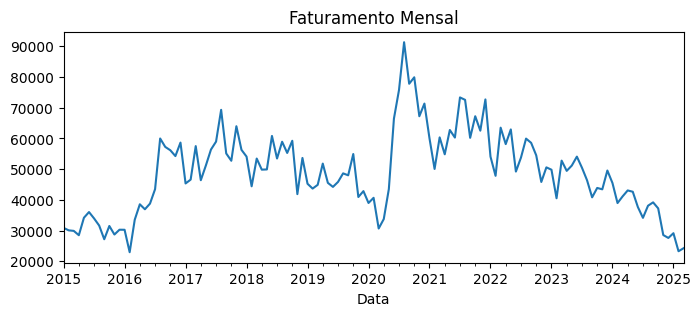

In [59]:
plt.figure(figsize=(8,3))
df.set_index('Data').resample('ME')['Total'].sum().plot()
plt.title('Faturamento Mensal')

Apesar de o gráfico ter bastante mudanças, parece, ainda que pouco pelo tamanho, que ele tem uma sazonalidade. Vamos diminuir para 5 anos e ver como se comporta.

In [60]:
mask = df['Data'].between('2020', '2026')
df_filtrado = df.loc[mask]


<Axes: xlabel='Data'>

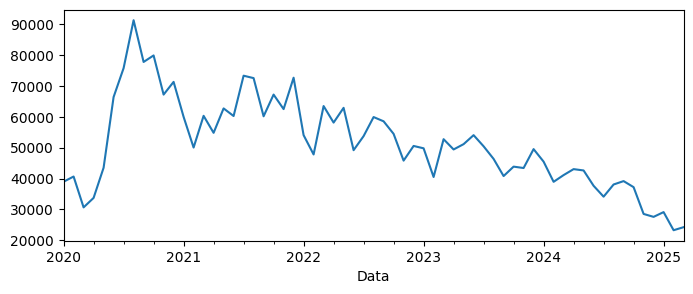

In [61]:
plt.figure(figsize=(8,3))
df_filtrado.set_index('Data').resample('ME')['Total'].sum().plot()

Precisamos fazer uma análise mais complexa sobre a data para entender sua `tendencia`, `sazonalidade` e no futuro realizar `forecasts` de venda.

In [62]:
vendas_mensais = df.set_index('Data').resample('ME')['Total'].sum()
vendas_semanais = df.set_index('Data').resample('W')['Total'].sum()
vendas_diarias = df.set_index('Data').resample('D')['Total'].sum()

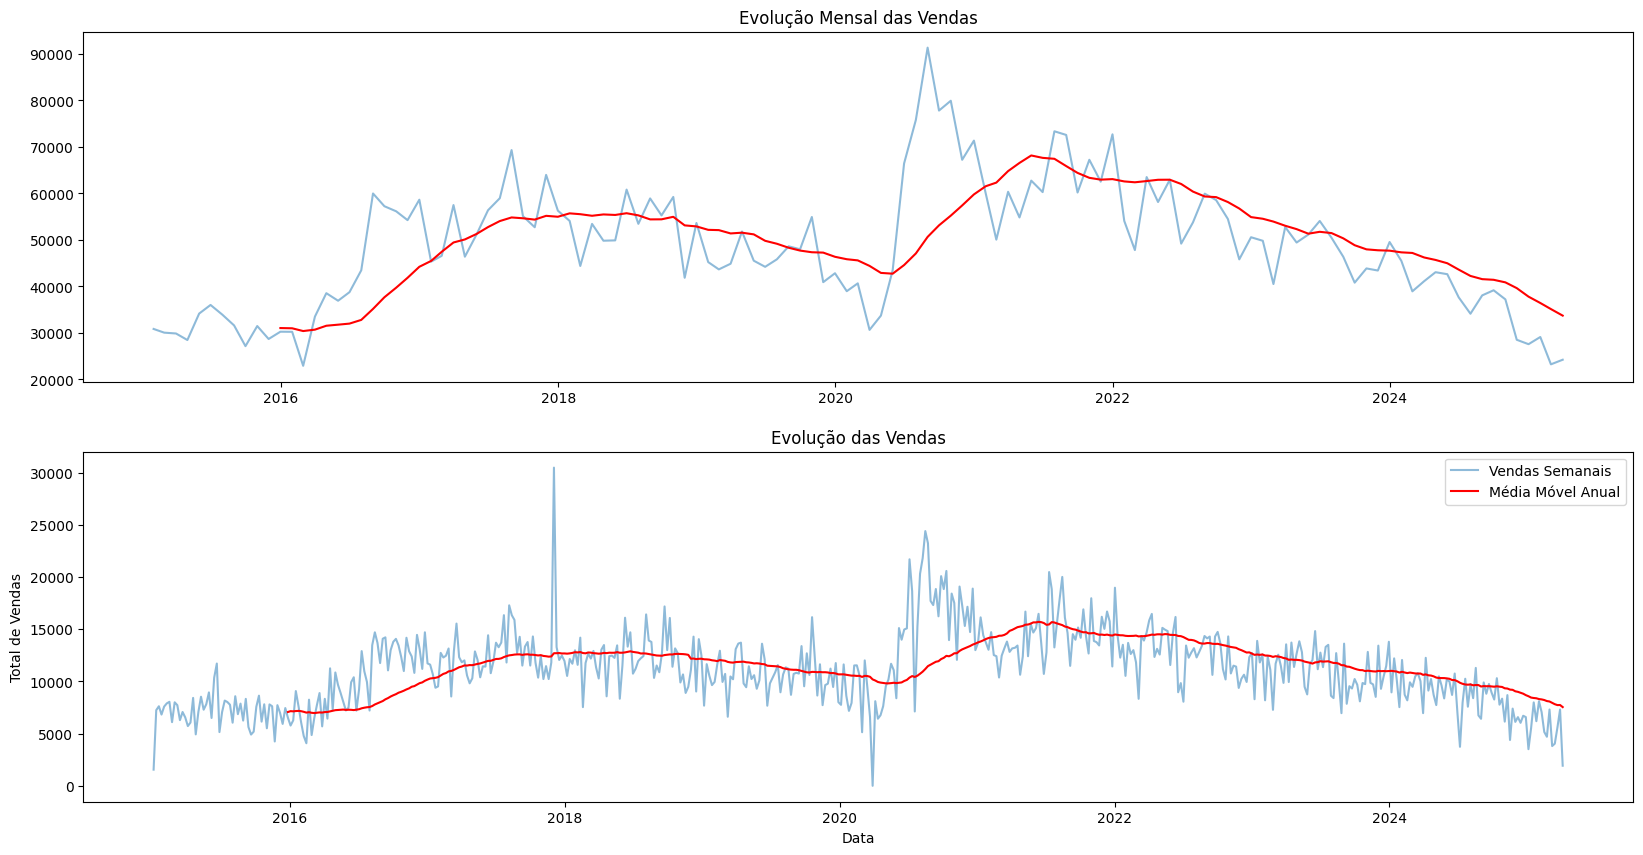

In [63]:
figure, axis = plt.subplots(2,1, figsize=(20,10))
plt.plot(vendas_semanais.index, vendas_semanais.values, label='Vendas Semanais', alpha=0.5)
axis[0].plot(vendas_mensais.index, vendas_mensais.values, label='Vendas Diárias', alpha=0.5)
axis[0].plot(vendas_mensais.rolling(12).mean(), label='Média Móvel Anual', color='red')
axis[0].set_title('Evolução Mensal das Vendas')
plt.plot(vendas_semanais.rolling(52).mean(), label='Média Móvel Anual', color='red')
plt.title("Evolução das Vendas")
plt.xlabel("Data")
plt.ylabel("Total de Vendas")
plt.legend()
plt.show()

Podemos ver nos gráficos a média mensal e anual de vendas. É notável que as vendas estão desacelerando.<br>
Vamos ver como é essa queda mensal.


In [64]:
mudanca_mensal_percentual = vendas_mensais.pct_change()*100
mudanca_mensal_percentual.describe()

count    122.000000
mean       0.919984
std       15.294926
min      -29.343413
25%       -8.971323
50%       -1.009944
75%       10.189349
max       52.696950
Name: Total, dtype: float64

In [65]:
df_temporal = df.sort_values('Data').set_index('Data')

In [66]:
df_temporal

,Produto,Quantidade,ValorMedio,Total,Func,Ndoc,Tipo,Codigo,Categoria,Quantidade_log
Data,,,,,,,,,,
2015-01-02,OLEO SELENIA SPRINTA 4T 20W-50,1,11.70,11.70,4,24039,C,913,OLEO,0.301030
2015-01-02,SOQUETE FAROL POP 2009/12/BIZ-125 11/,1,5.45,5.45,4,32088,P,5987,SOQUETE,0.301030
2015-01-02,JUNTA CABECOTE CG,1,2.15,2.15,4,32064,P,346,JUNTA,0.301030
2015-01-02,ROLAM. 6203 IMP. COROA BIZ/XL TRAS. B,1,5.79,5.79,4,32040,P,394,ROLAM.,0.301030
2015-01-02,ROLAM. 6004 IMP. COROA CG150/YBR/EIXO,1,5.31,5.31,3,32060,P,1813,ROLAM.,0.301030
...,...,...,...,...,...,...,...,...,...,...
2025-03-31,RET. EIXO PARTIDA CG/ML/TIT IMP/CG-15,1,3.97,3.97,4,166078,P,4451,RET.,0.301030
2025-03-31,EIXO SEC. PINHAO CG-150 KS 2009/11-FA,1,78.82,78.82,4,166078,P,4541,EIXO,0.301030
2025-03-31,RET. EIXO EMB. CG-150/YBR/TWISTER VED,1,3.10,3.10,4,166078,P,4468,RET.,0.301030


<Axes: title={'center': 'Média Móvel 7 dias - Vendas Diárias'}, xlabel='Data'>

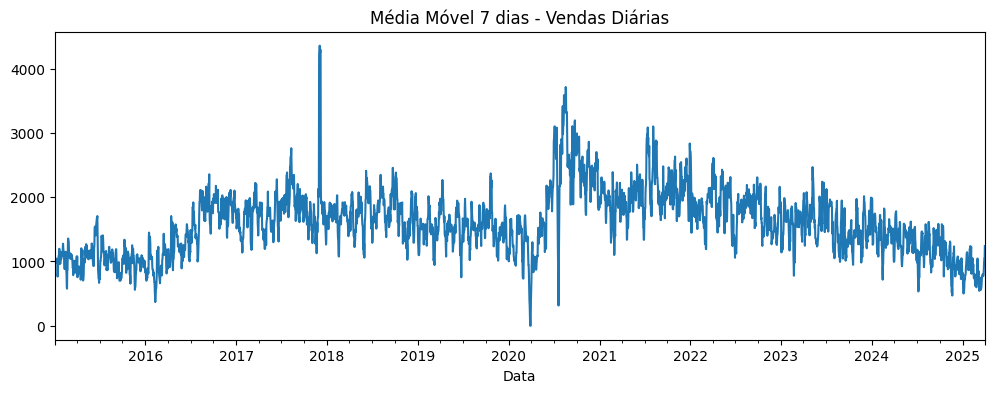

In [67]:
vendas_diarias.rolling(7).mean().plot(figsize=(12,4), title='Média Móvel 7 dias - Vendas Diárias')

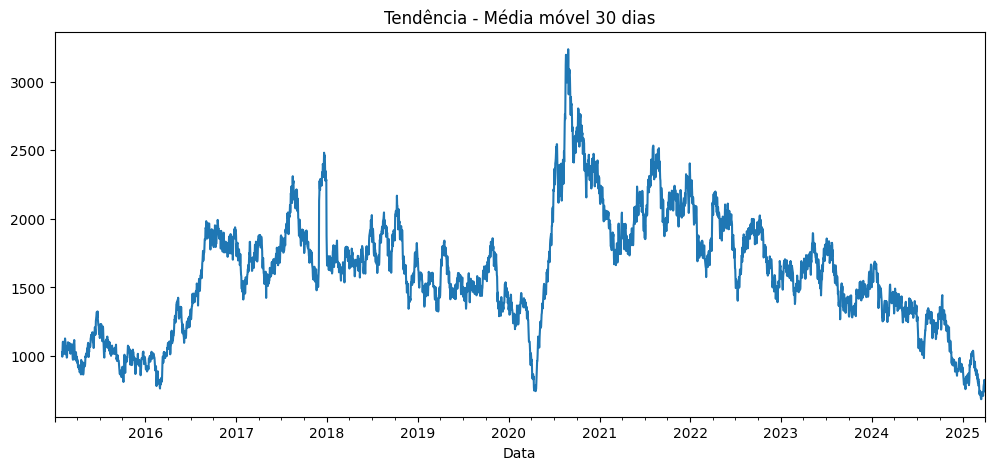

In [68]:
vendas_diarias.rolling(window=30).mean().plot(figsize=(12,5))
plt.title("Tendência - Média móvel 30 dias")
plt.show()

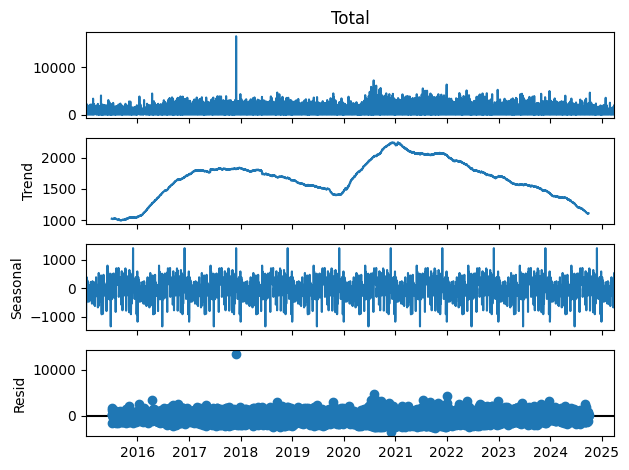

In [69]:
decomp = seasonal_decompose(vendas_diarias, model='additive', period=365)
decomp.plot()
plt.show()

In [70]:
df_temporal['Ano'] = df_temporal.index.year
df_temporal['Mes'] = df_temporal.index.month
df_temporal['DiaSemana'] = df_temporal.index.dayofweek
df_temporal['Dia'] = df_temporal.index.day

<Axes: xlabel='Mes', ylabel='count'>

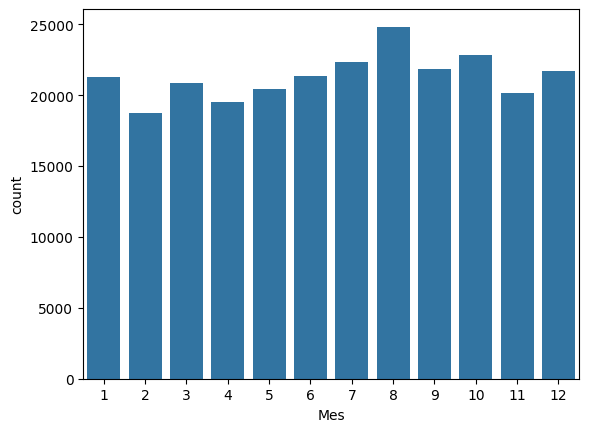

In [71]:
sns.countplot(x='Mes', data=df_temporal)

Durante o período de dados que temos, conseguimos ver que o melhores meses tendem a ser de 7~10 (Julho a Outubro). Depois vamos ver quais as peças que mais sem em cada perído, assim teremos uma noção se será algo relacionado a clima, festas etc. <br>
**OBS**: *Aqui é apenas a contagem de vendas, não é o gráfico sobre o faturamento que veremos em seguida.*

<Axes: xlabel='DiaSemana', ylabel='count'>

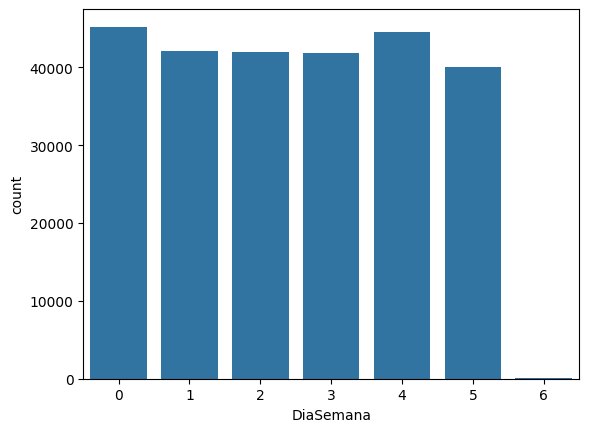

In [72]:
sns.countplot(x='DiaSemana', data=df_temporal)

Domingo a princípio a loja não funciona.

<Axes: title={'center': 'Sazonalidade Diária Anual'}, xlabel='Data'>

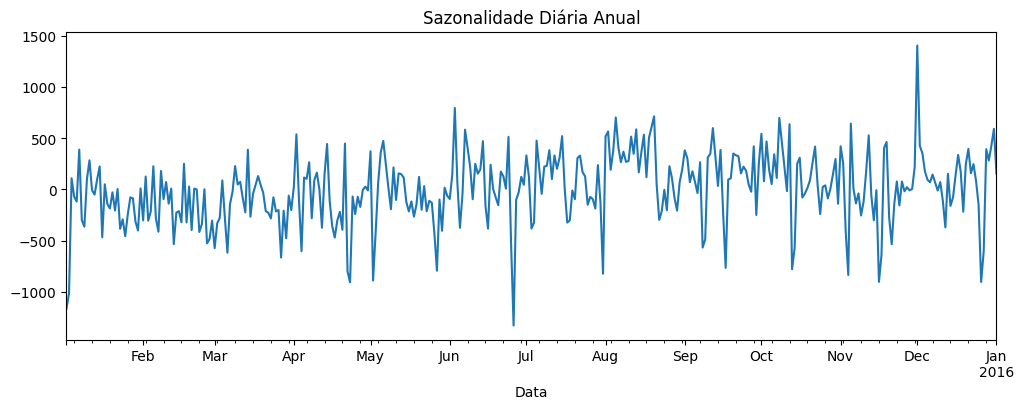

In [73]:
decomp.seasonal[:365].plot(figsize=(12,4), title='Sazonalidade Diária Anual')

Podemos ver a sazonalidade diária, no entando vamos tentar entender algo que nos ajude mais, vamos explorar a sazonalidade mensal durante o ano.

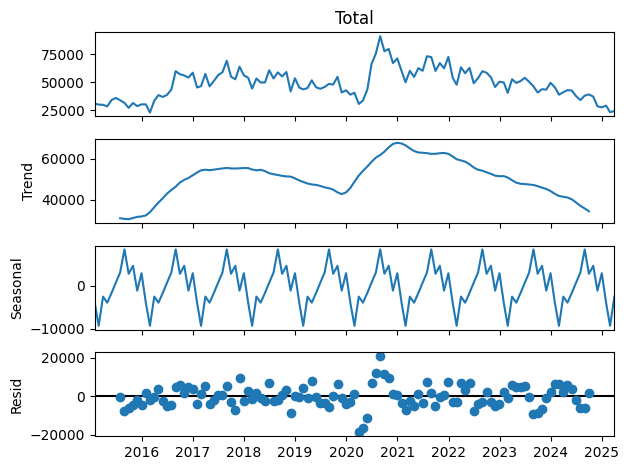

In [74]:
decomp_mensal = seasonal_decompose(vendas_mensais, model='additive', period=12)
decomp_mensal.plot()
plt.show()

decomp_mensal.seasonal[0:12].plot(figsize=(12,4), title='Sazonalidade Mensal')

media_ano_mes = df_temporal.groupby(['Ano','Mes'])['Total'].sum()

media_por_mes = (
    media_ano_mes
    .groupby('Mes')
    .mean()
)

ax = media_por_mes.plot(kind='bar')
ax.bar_label(ax.containers[0], fmt='%.0f')
ax.set_title('Média de Vendas por Mês  (em R$)')
ax.set_ylabel('Valor (R$)')
plt.xticks(rotation=35)
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.show()

Agora podemos confirar nossa teoria dos melhores e piores meses, sendo respectivamente de 7~10 e 1~4. <BR>
**Melhor mês:** Agosto <br>
**Pior mês**: Fevereiro

Acima temos a média de venda por mês, onde de novo os melhores meses são os 7 à 10 (Julho a outubro). <br>
Podemos ver quais são as melhores categorias nesses mêses.

Agora vamos ver como as vendas se comportam em relação aos dias de semana.

decomp_semana = seasonal_decompose(vendas_diarias, model='additive', period=7)
decomp_semana.plot()
plt.show()

decomp_semana.seasonal[:14].plot(figsize=(12,4), title='Sazonalidade Semanal')

Analisando a sazonalidade semanal, vemos que segunda-feira e sexta-feira têm um movimento um pouco maior comparado aos outros dias. Apesar disso, o valor não se diferencia muito aos longo dos dias da semana.

### Análise Bivariada

#### Variáveis Numérica x Numérica

##### Preco Médio x Quantidade
Aqui vamos analisar se o preço médio do produto interfere na sua quantidade de venda. Ou seja, produtos caros tendem a sair apenas de 1 em 1 e mais baratos em maior quantidade por venda.

In [75]:
df_bivar_qtd_vm = df[['Quantidade', 'ValorMedio']]
df_bivar_qtd_vm

,Quantidade,ValorMedio
0,1,11.70
92915,1,18.86
92916,1,20.96
92917,1,4.66
92918,1,4.65
...,...,...
92865,1,4.16
92866,1,5.44
92867,1,0.94
255857,1,8.77


Text(0.5, 1.0, 'Relação quantidade e valor médio')

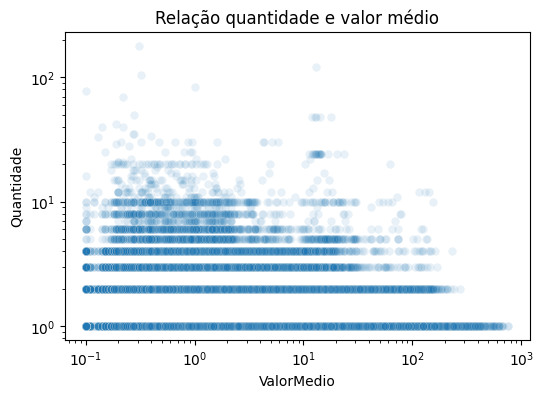

In [76]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_bivar_qtd_vm, x='ValorMedio', y='Quantidade', alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.title('Relação quantidade e valor médio')

In [77]:
spearman_corr, _ = spearmanr(df_bivar_qtd_vm['ValorMedio'], df_bivar_qtd_vm['Quantidade'])
print("Correlação Spearman:", spearman_corr)

Correlação Spearman: -0.39967986848834575


A correlação está moderada, o que quer dizer que não é fator determinante, mas é algo a se considerar. Vamos ver como as quantidades se comprotam quando comparadas a categoria, pois a correlação de quantidade e total pode variar muito a depender da categoria da peça.

In [78]:
top10_categorias = (
    df['Categoria']
      .value_counts() 
      .head(10) 
      .index
)

# Filtrar o DataFrame
df_top10 = df[df['Categoria'].isin(top10_categorias)]


In [79]:
top10_categorias = (
    df.groupby('Categoria')['Quantidade']
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

df_top10 = df[df['Categoria'].isin(top10_categorias)]

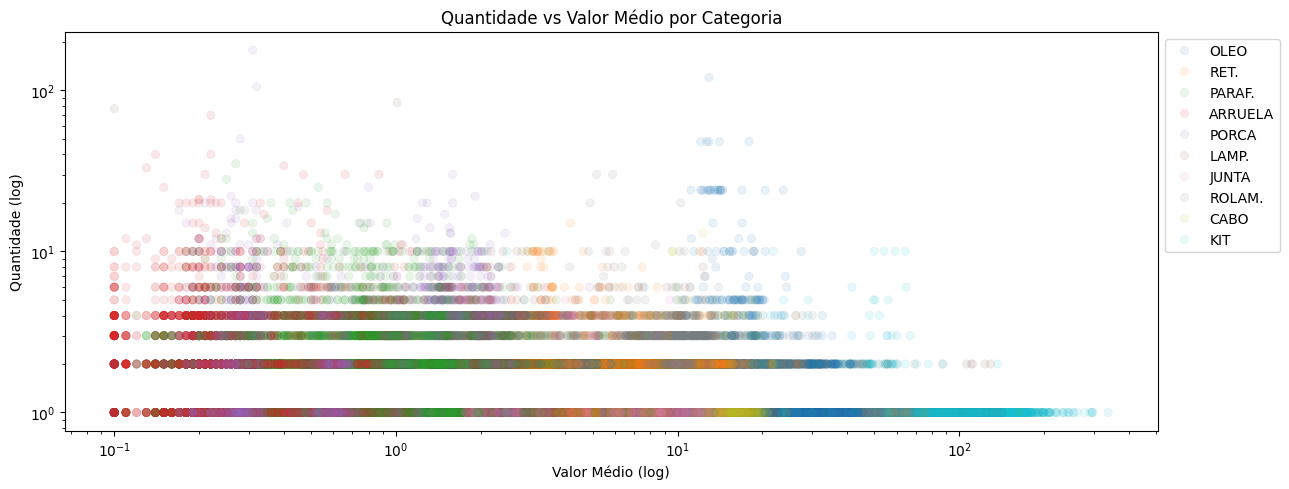

In [80]:
plt.figure(figsize=(13,5))
sns.scatterplot(data=df_top10,
                x='ValorMedio',
                y='Quantidade',
                hue='Categoria',
                alpha=0.1,
                edgecolor=None)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Valor Médio (log)')
plt.ylabel('Quantidade (log)')
plt.title('Quantidade vs Valor Médio por Categoria')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### Análise por Número de Pedido x Total

In [81]:
df_pedido = df.groupby('Ndoc').agg({
    'Data': 'first',
    'Func': 'first',
    'Tipo': 'first',
    'Quantidade': 'sum',
    'Total': 'sum',
    'Produto': lambda x: x.nunique()
})
df_pedido

,Data,Func,Tipo,Quantidade,Total,Produto
Ndoc,,,,,,
1,2018-12-21,1,C,2,50.24,2
2,2018-12-21,3,C,21,97.52,3
3,2018-12-21,3,C,2,125.36,2
4,2018-12-21,3,C,3,59.66,3
5,2019-01-02,3,C,1,30.33,1
...,...,...,...,...,...,...
166080,2025-03-31,4,P,1,10.31,1
166085,2025-03-31,4,P,1,5.59,1
166087,2025-03-31,4,P,1,43.71,1


In [82]:
tk_medio = df_pedido['Total'].mean()
tk_max = df_pedido['Total'].max()
tk_min = df_pedido['Total'].min()
print(f'Ticket máximo de R${tk_max:.2f}.')
print(f'Ticket médio de R${tk_medio:.2f}.')
print(f'Ticket mínimo de R${tk_min:.2f}.')

Ticket máximo de R$13533.24.
Ticket médio de R$52.97.
Ticket mínimo de R$0.10.


Nosso ticket médio é de R$52,97. <br>
Vamos ver como ele se comporta ao longo do tempo, para assim conseguirmos ver se está subindo ou caindo.

In [83]:
media_produtos = df_pedido['Quantidade'].mean()
print(f'A média de quantidade de produtos por venda é de {media_produtos:.1f} produtos.')

A média de quantidade de produtos por venda é de 2.9 produtos.


In [84]:
por_tipo = df_pedido.groupby('Tipo')
por_tipo['Total'].describe()

,count,mean,std,min,25%,50%,75%,max
Tipo,,,,,,,,
C,25207.0,117.576683,132.688577,0.28,33.46,79.230,156.75,3441.40
P,87868.0,34.435496,77.718043,0.10,6.84,15.785,32.25,13533.24


In [85]:
ticket_medio_ano = df_pedido.groupby('Ano')['Total'].mean().reset_index(name='TicketMedio')

KeyError: 'Ano'

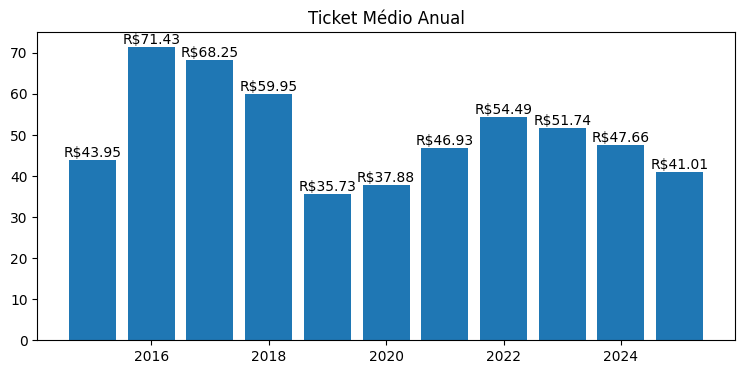

In [ ]:
plt.figure(figsize=(9,4))
plt.bar(data=ticket_medio_ano, x='Ano', height='TicketMedio')
plt.title('Ticket Médio Anual')
plt.bar_label(plt.gca().containers[0], fmt='R$%.2f')
plt.show()

##### Categoria x Quantidade e Total
Agora vamos analisar quais categorias se descatam a cada ano. <br>
Separando em quantidade e Valor total <br>
Por hora vamos ver apenas a comparação por ano. Depois vamos analisar os mêses.

In [ ]:
df['Ano'] = df['Data'].dt.year
df['Mes'] = df['Data'].dt.month
df[['Ndoc', 'Ano']]
venda_quant_cat_ano = (
    df.groupby(['Ano','Categoria'], as_index=False)['Quantidade']
    .sum()
)
venda_total_cat_ano = (
    df.groupby(['Ano', 'Categoria'], as_index=False)['Total']
      .sum()
)


---

###### Quantidade


In [ ]:
venda_quant_cat_ano['Rank'] = (
    venda_quant_cat_ano
    .groupby('Ano')['Quantidade']
    .rank(method='dense', ascending=False)
)

In [ ]:
venda_quant_cat_ano.loc[venda_quant_cat_ano['Rank']<= 10].sort_values(['Ano','Rank'])

,Ano,Categoria,Quantidade,Rank
102,2015,OLEO,2621,1.0
105,2015,PARAF.,2440,2.0
89,2015,LAMP.,1582,3.0
10,2015,ARRUELA,1512,4.0
139,2015,RET.,1320,5.0
...,...,...,...,...
1826,2025,LAMP.,145,6.0
1775,2025,CABO,141,7.0
1863,2025,ROLAM.,126,8.0
1761,2025,ARRUELA,120,9.0


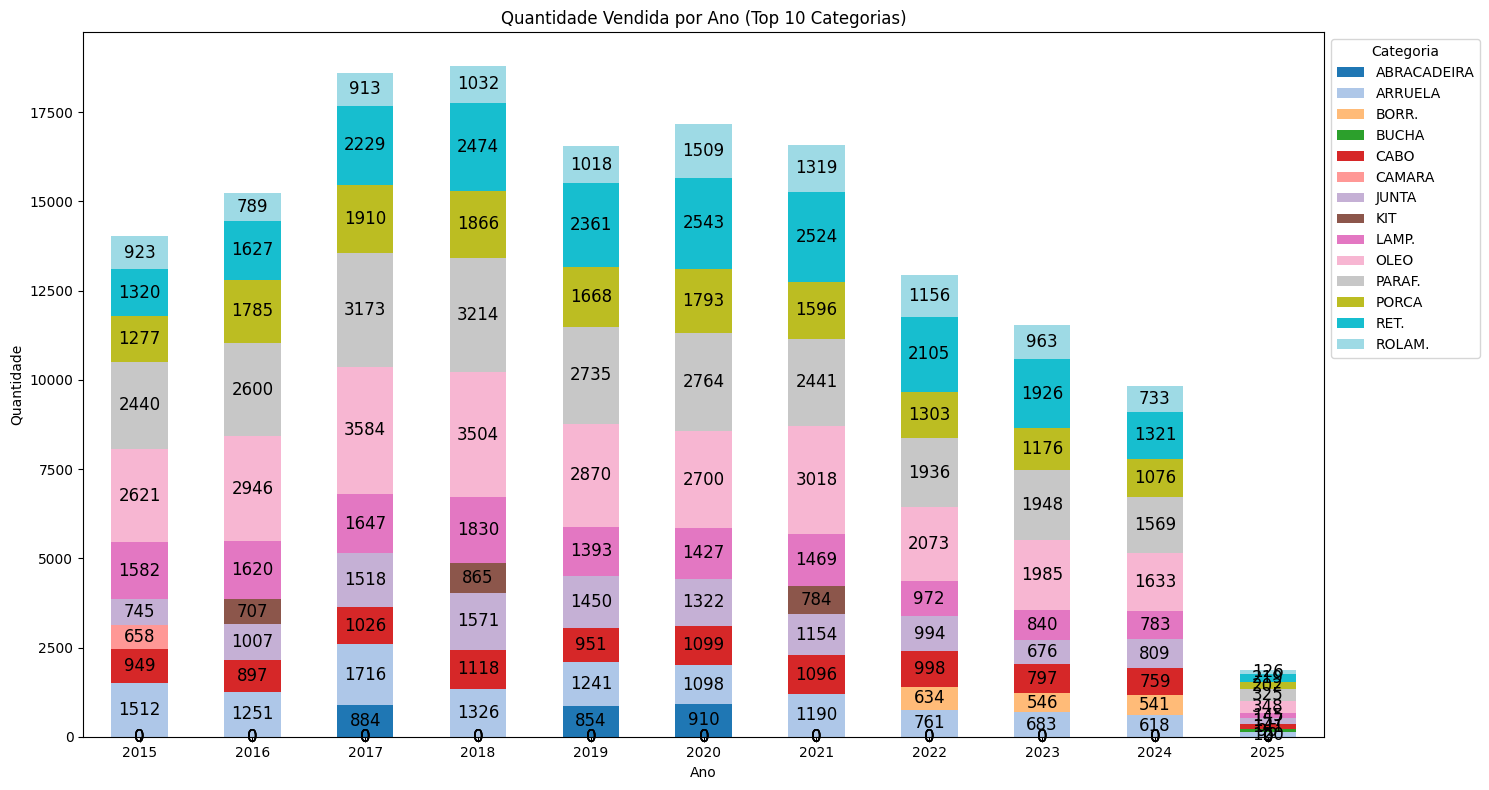

In [ ]:
pivot_ano_cat = (
    venda_quant_cat_ano
    .loc[venda_quant_cat_ano['Rank']<=10]
    .groupby(['Ano','Categoria'])['Quantidade']
    .sum()
    .unstack(fill_value=0)
)
fig, ax = plt.subplots(figsize=(15,8))

pivot_ano_cat.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab20', 
    ax=ax
)

ax.set_title('Quantidade Vendida por Ano (Top 10 Categorias)')
ax.set_xlabel('Ano')
ax.set_ylabel('Quantidade')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Categoria', bbox_to_anchor=(1,1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, color="black")

plt.tight_layout()
plt.show()

In [ ]:
venda_quant_cat_ano.loc[venda_quant_cat_ano['Rank']<=10, 'Categoria'].value_counts()

Categoria
ARRUELA        11
CABO           11
JUNTA          11
LAMP.          11
OLEO           11
PARAF.         11
RET.           11
PORCA          11
ROLAM.         11
KIT             3
BORR.           3
ABRACADEIRA     3
CAMARA          1
BUCHA           1
Name: count, dtype: int64

Quanto a quantidade, temos 9 produtos que apareceram no top 10 em 11 anos, sendo eles `ARRUELA`, `CABO`, `JUNTA`, `LAMP.`, `OLEO`, `PARAF`, `RET.`, `PORCA`, `ROLAM`. Como 2025 temos poucos meses de venda registrados seu gráfico é reduzido, vamos ver como é separado até agora:

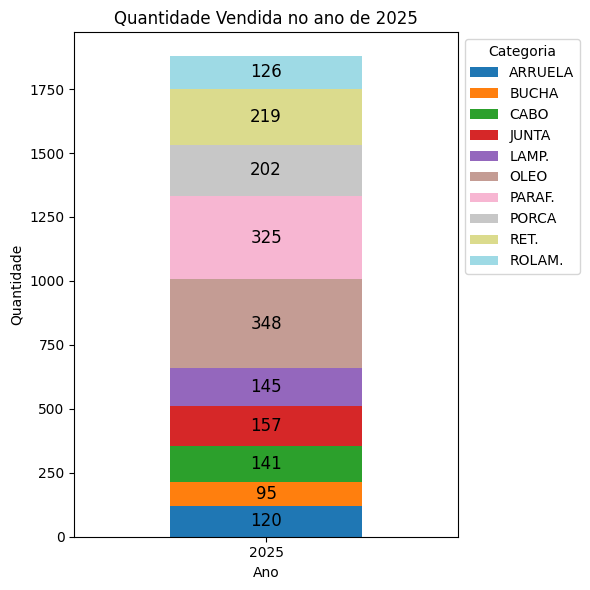

In [ ]:
pivot_2025_cat = (
    venda_quant_cat_ano
    .loc[venda_quant_cat_ano['Rank']<=10].loc[venda_quant_cat_ano['Ano'] == 2025]
    .groupby(['Ano','Categoria'])['Quantidade']
    .sum()
    .unstack(fill_value=0)
)
fig, ax = plt.subplots(figsize=(6,6))

pivot_2025_cat.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab20', 
    ax=ax
)

ax.set_title('Quantidade Vendida no ano de 2025')
ax.set_xlabel('Ano')
ax.set_ylabel('Quantidade')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Categoria', bbox_to_anchor=(1,1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, color="black")

plt.tight_layout()
plt.show()

---

###### Total

In [ ]:
venda_total_cat_ano

,Ano,Categoria,Total
0,2015,ABRACADEIRA,137.14
1,2015,ACIO.,347.30
2,2015,AGULHA,405.18
3,2015,ALAVANCA,20.56
4,2015,ALCA,70.94
...,...,...,...
1879,2025,VELA,693.25
1880,2025,VELOCIMETRO,74.25
1881,2025,VIRABREQUIM,202.86
1882,2025,VISEIRA,434.75


In [ ]:
venda_total_cat_ano['Rank'] = (
    venda_total_cat_ano
    .groupby('Ano')['Total']
    .rank(method='dense', ascending=False)
)

In [ ]:
venda_total_cat_ano.loc[venda_total_cat_ano['Rank']<= 10].sort_values(['Ano','Rank'])

,Ano,Categoria,Total,Rank
102,2015,OLEO,34007.09,1.0
120,2015,PNEU,32818.80,2.0
15,2015,BATERIA,29974.07,3.0
87,2015,KIT,27448.57,4.0
32,2015,CAMARA,17473.23,5.0
...,...,...,...,...
1787,2025,CILINDRO,2017.60,6.0
1780,2025,CAPACETE,2003.71,7.0
1863,2025,ROLAM.,1619.57,8.0
1778,2025,CAMARA,1467.87,9.0


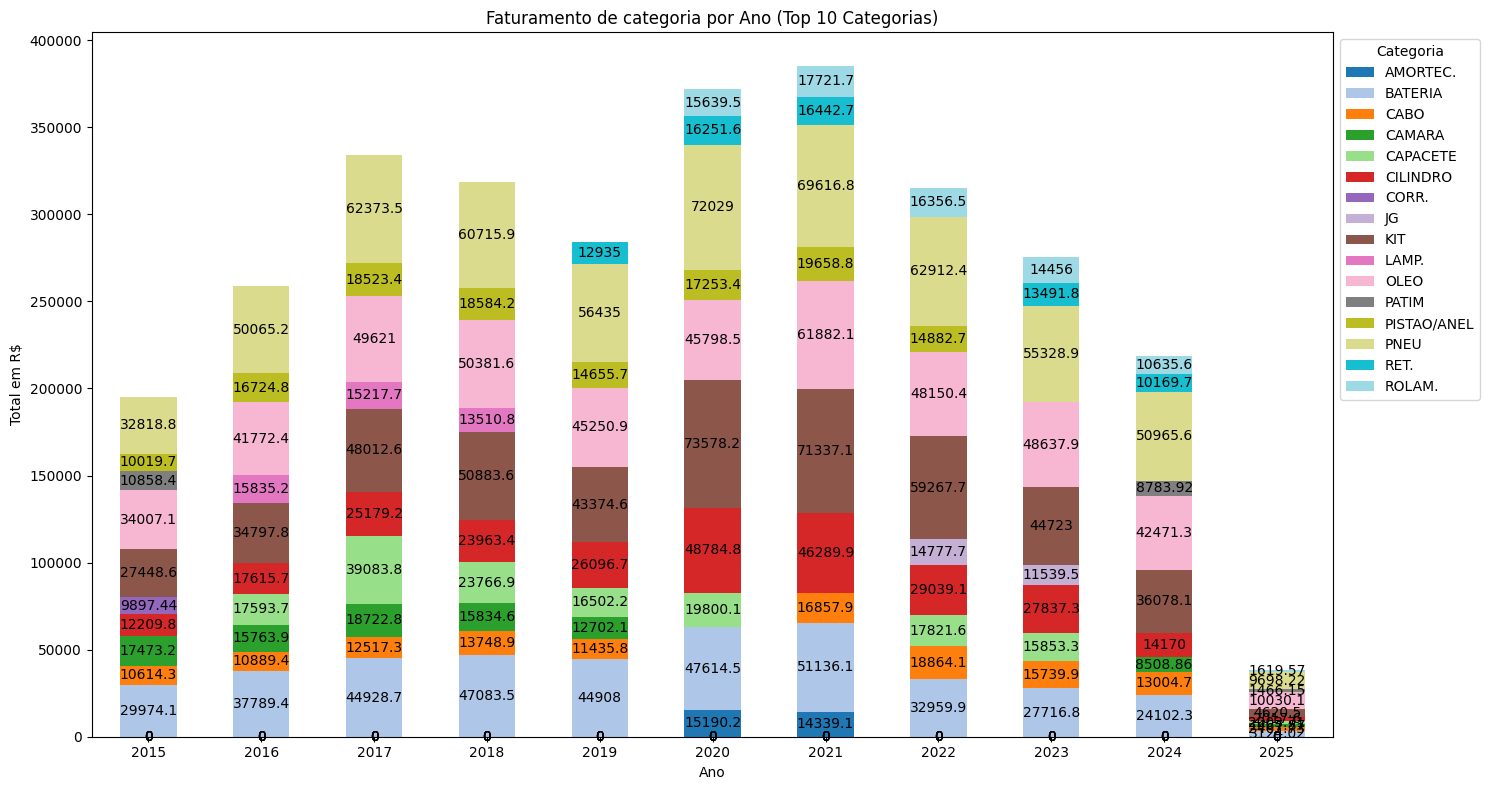

In [ ]:
pivot_ano_cat_total = (
    venda_total_cat_ano
    .loc[venda_total_cat_ano['Rank']<=10]
    .groupby(['Ano','Categoria'])['Total']
    .sum()
    .unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(15,8))
pivot_ano_cat_total.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab20', 
    ax=ax
)

ax.set_title('Faturamento de categoria por Ano (Top 10 Categorias)')
ax.set_xlabel('Ano')
ax.set_ylabel('Total em R$')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Categoria', bbox_to_anchor=(1,1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, color="black")

plt.tight_layout()
plt.show()

In [ ]:
venda_total_cat_ano.loc[venda_total_cat_ano['Rank']<=10, 'Categoria'].value_counts()

Categoria
BATERIA        11
CILINDRO       11
OLEO           11
KIT            11
PNEU           11
CABO           10
PISTAO/ANEL     8
CAPACETE        8
CAMARA          7
ROLAM.          6
RET.            5
PATIM           3
LAMP.           3
AMORTEC.        2
JG              2
CORR.           1
Name: count, dtype: int64

Para o valor de faturamento total, temos apenas 5 categorias presentes em 11 anos, sendo elas `BATERIA`, `CILINDRO`, `OLEO`, `KIT` e `PNEU`.

Do ano de 2018 até 2024 temos presente no top 5 das categorias `PNEU`, `OLEO`, `KIT`, `BATERIA` e `CILINDRO` em termos de faturamento, exatamente os 5 que sempre estão presentes no top 10. Indicando que são produtos chave.

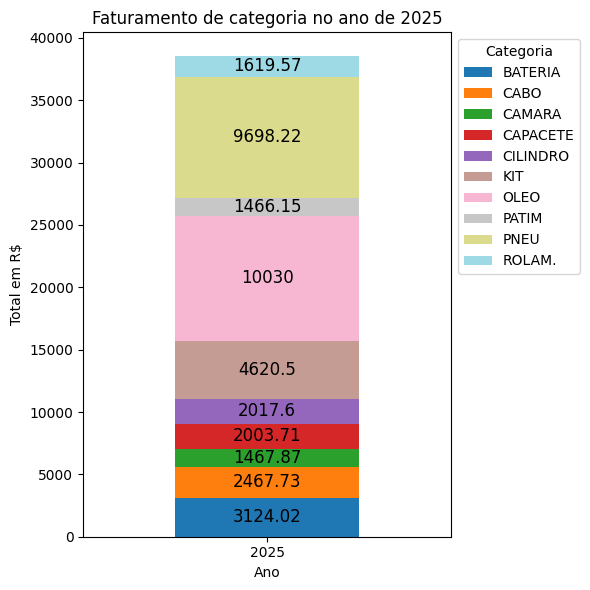

In [ ]:
pivot_2025_cat_total = (
    venda_total_cat_ano
    .loc[venda_total_cat_ano['Rank']<=10].loc[venda_total_cat_ano['Ano'] == 2025]
    .groupby(['Ano','Categoria'])['Total']
    .sum()
    .unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(6,6))
pivot_2025_cat_total.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab20', 
    ax=ax
)

ax.set_title('Faturamento de categoria no ano de 2025')
ax.set_xlabel('Ano')
ax.set_ylabel('Total em R$')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Categoria', bbox_to_anchor=(1,1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, color="black")

plt.tight_layout()
plt.show()


In [ ]:
for ano in range(2015, 2025):
    soma_ano = venda_total_cat_ano.loc[venda_total_cat_ano['Ano'] == ano, 'Total'].sum()
    soma_top10 = venda_total_cat_ano.loc[venda_total_cat_ano['Rank']<=10].loc[venda_total_cat_ano['Ano'] == ano, 'Total'].sum()
    print(f'O faturamento das 10 melhores categorias no ano de {ano} é igual a {((soma_top10 / soma_ano)*100):.2f}% do faturamento total anual.')

O faturamento das 10 melhores categorias no ano de 2015 é igual a 52.43% do faturamento total anual
O faturamento das 10 melhores categorias no ano de 2016 é igual a 48.78% do faturamento total anual
O faturamento das 10 melhores categorias no ano de 2017 é igual a 50.65% do faturamento total anual
O faturamento das 10 melhores categorias no ano de 2018 é igual a 50.17% do faturamento total anual
O faturamento das 10 melhores categorias no ano de 2019 é igual a 51.10% do faturamento total anual
O faturamento das 10 melhores categorias no ano de 2020 é igual a 51.85% do faturamento total anual
O faturamento das 10 melhores categorias no ano de 2021 é igual a 50.91% do faturamento total anual
O faturamento das 10 melhores categorias no ano de 2022 é igual a 47.82% do faturamento total anual
O faturamento das 10 melhores categorias no ano de 2023 é igual a 48.12% do faturamento total anual
O faturamento das 10 melhores categorias no ano de 2024 é igual a 48.26% do faturamento total anual


In [ ]:
soma_ano_2025 = venda_total_cat_ano.loc[venda_total_cat_ano['Ano'] == 2025, 'Total'].sum()
soma_top10_2025 = venda_total_cat_ano.loc[venda_total_cat_ano['Rank']<=10].loc[venda_total_cat_ano['Ano'] == 2025, 'Total'].sum()
print(f'O faturamento das 10 melhores categorias em 2025 está sendo igual a {((soma_top10_2025 / soma_ano_2025)*100):.2f}% do faturamento total anual') 

O faturamento das 10 melhores categorias em 2025 está sendo igual a 50.29% do faturamento total anual


---

In [ ]:
venda_quant_cat_mes = (
    df.groupby(['Mes','Categoria'], as_index=False)['Quantidade']
    .sum()
)
venda_total_cat_mes = (
    df.groupby(['Mes', 'Categoria'], as_index=False)['Total']
      .sum()
)


In [ ]:
venda_quant_cat_mes['Rank'] = (
    venda_quant_cat_mes
    .groupby('Mes')['Quantidade']
    .rank(method='min', ascending=False)  # Tive que usar min que tem 2 valores colidindo
)

In [ ]:
venda_quant_cat_mes.loc[venda_quant_cat_mes['Rank']<= 10].sort_values(['Mes','Rank'])

,Mes,Categoria,Quantidade,Rank
110,1,OLEO,2381,1.0
113,1,PARAF.,2097,2.0
144,1,RET.,1686,3.0
129,1,PORCA,1454,4.0
98,1,LAMP.,1194,5.0
...,...,...,...,...
2076,12,JUNTA,917,6.0
1994,12,ARRUELA,912,7.0
2128,12,ROLAM.,898,8.0
2013,12,CABO,840,9.0


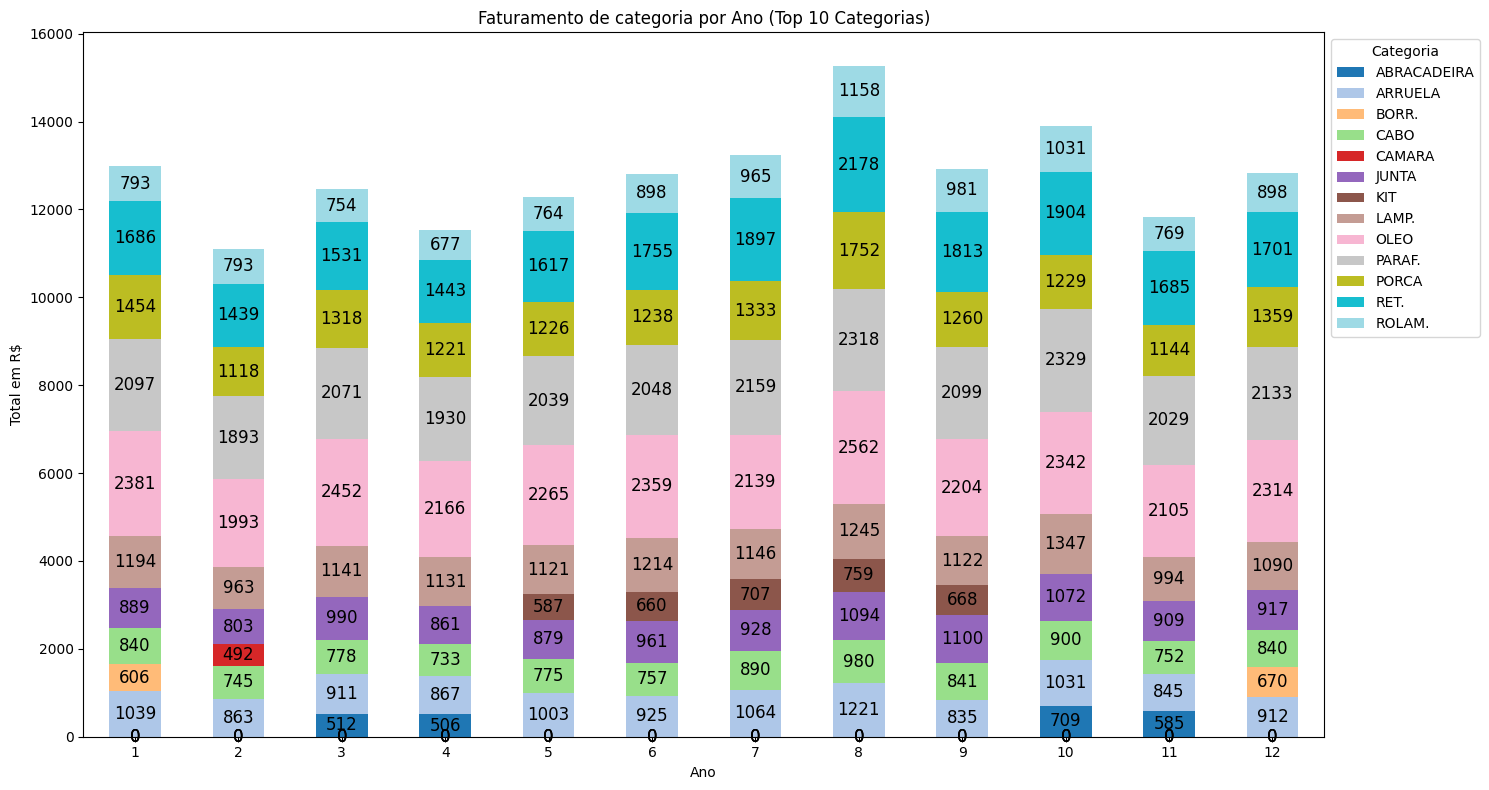

In [ ]:
pivot_ano_cat_total = (
    venda_quant_cat_mes
    .loc[venda_quant_cat_mes['Rank']<=10]
    .groupby(['Mes','Categoria'])['Quantidade']
    .sum()
    .unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(15,8))
pivot_ano_cat_total.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab20', 
    ax=ax
)

ax.set_title('Faturamento de categoria por Ano (Top 10 Categorias)')
ax.set_xlabel('Ano')
ax.set_ylabel('Total em R$')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Categoria', bbox_to_anchor=(1,1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, color="black")

plt.tight_layout()
plt.show()

Dos meses 5 à 9 a categoria `KIT` aparece. São meses de chuva. Além disso a categoria `BORR.` aparece nos meses 12 e 1 o que pode indicar que existe uma razão, já que são meses subsequentes. <Br>
Quase todas as categorias tem um aumento de aprox *10%* no mês 8.

---


In [ ]:
venda_total_cat_mes['Rank'] = (
    venda_total_cat_mes
    .groupby('Mes')['Total']
    .rank(method='min', ascending=False)  # Tive que usar min que tem 2 valores colidindo
)

In [ ]:
venda_total_cat_mes.loc[venda_total_cat_mes['Rank'] <11].sort_values(['Mes', 'Rank'])

,Mes,Categoria,Total,Rank
127,1,PNEU,51539.57,1.0
110,1,OLEO,42544.50,2.0
96,1,KIT,34986.57,3.0
16,1,BATERIA,31589.27,4.0
45,1,CILINDRO,22382.38,5.0
...,...,...,...,...
2018,12,CAPACETE,13453.53,6.0
2016,12,CAMARA,13133.06,7.0
2013,12,CABO,12531.66,8.0
2106,12,PISTAO/ANEL,11555.86,9.0


---

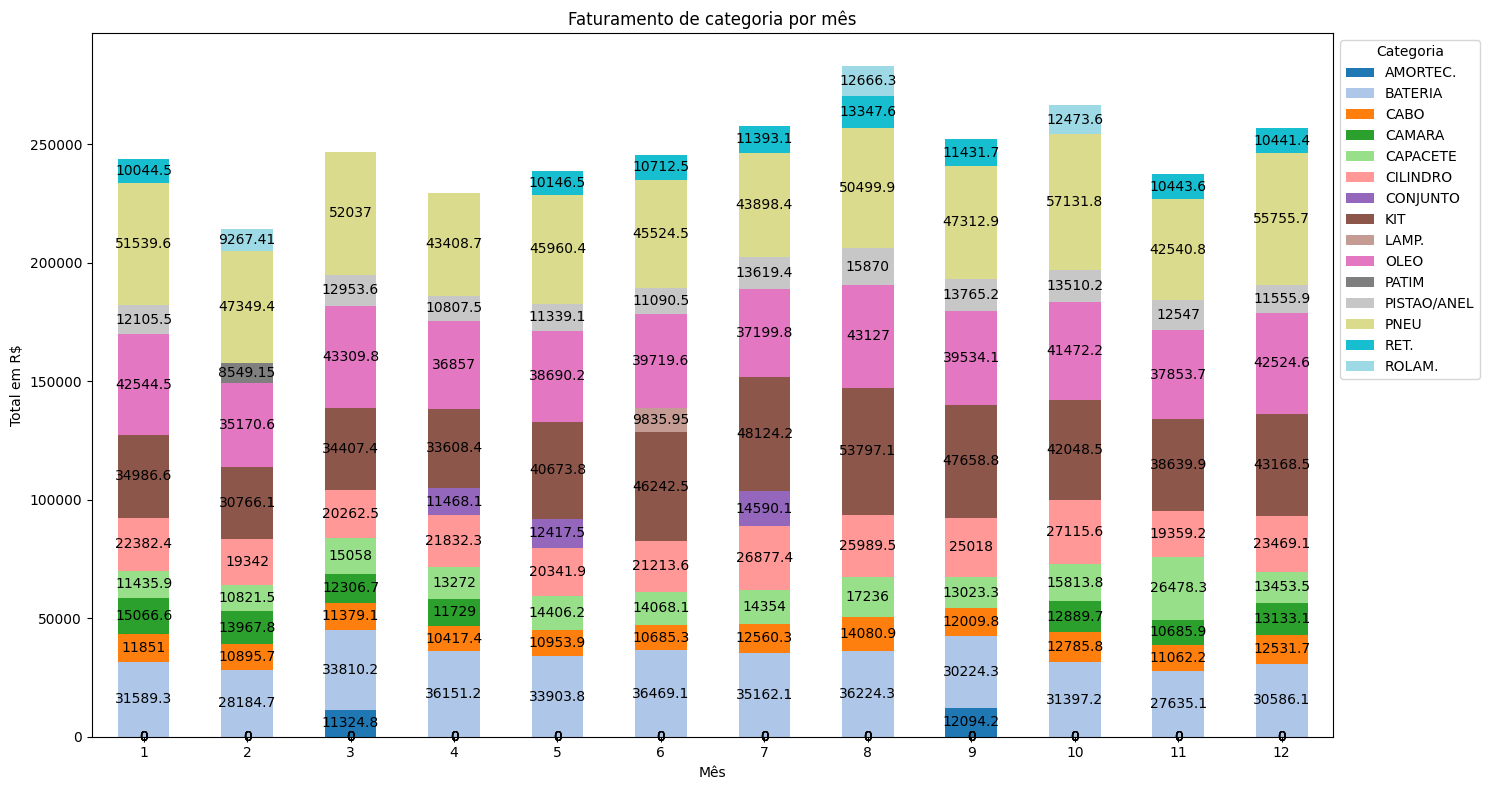

In [ ]:
pivot_mes_cat_total = (
    venda_total_cat_mes
    .loc[venda_total_cat_mes['Rank']<=10]
    .groupby(['Mes','Categoria'])['Total']
    .sum()
    .unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(15,8))
pivot_mes_cat_total.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab20', 
    ax=ax
)

ax.set_title('Faturamento de categoria por mês')
ax.set_xlabel('Mês')
ax.set_ylabel('Total em R$')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Categoria', bbox_to_anchor=(1,1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, color="black")

plt.tight_layout()
plt.show()

A categoria `CONJUNTO` aparece no top de faturamento nos meses 4,5 e 7. São os meses de chuva.

In [ ]:
venda_total_cat_mes.loc[venda_total_cat_mes['Rank']<=10, 'Categoria'].value_counts()

Categoria
BATERIA        12
CABO           12
CAPACETE       12
KIT            12
CILINDRO       12
OLEO           12
PNEU           12
PISTAO/ANEL    11
RET.            8
CAMARA          7
ROLAM.          3
CONJUNTO        3
AMORTEC.        2
PATIM           1
LAMP.           1
Name: count, dtype: int64

7 categorias aparecem todos os meses no top 10 vendas, `BATERIA`, `CABO`, `CAPACETE`, `KIT`, `CILINDRO`, `OLEO` e `PNEU`.